In [4]:
%env CUDA_VISIBLE_DEVICES ""

env: CUDA_VISIBLE_DEVICES=""


In [5]:
from mp_20_utils import load_all_data
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len = load_all_data()

In [6]:
import torch
from wyckoff_transformer import WyckoffTransformerModel
device = torch.device('cpu')
d_hid = 170  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.1
# Not all SGs are present in the dataset
n_space_groups = len(spacegroup_to_ids)

model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    max_enumeration = 7,
    d_space_groups = 16,
    d_sites = 64,
    d_species = 64,
    nhead=nhead,
    d_hid=d_hid,
    max_len=max_len,
    nlayers=nlayers,
    dropout=dropout).to(device)
model.load_state_dict(torch.load('checkpoints/2024-04-10_04-13-19/best_model_params.pt', map_location=device))
model.eval()

WyckoffTransformerModel(
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=145, out_features=145, bias=True)
        )
        (linear1): Linear(in_features=145, out_features=170, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=170, out_features=145, bias=True)
        (norm1): LayerNorm((145,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((145,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (sites_embedding): Embedding(89, 64)
  (species_embedding): Embedding(91, 64)
  (space_groups_embedding): Embedding(177, 16)
  (linear): Linear(in_features=145, out_features=188, bias=True)
)

In [7]:
from torch import optim
from torch import nn

class CalibrateFromLogits(nn.Module):
    def __init__(
        self, lr:float=0.1, max_iter:int=100, n_steps:int=10,
        device:str='cpu'):
        super().__init__()
        self.lr = lr
        self.max_iter = max_iter
        self.n_steps = n_steps
        self.device = device
        self.temperature = nn.Parameter(torch.ones(1, device=device), requires_grad=True)
        self.optimizer = optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)
        self.criterion = nn.CrossEntropyLoss()
        self.t_max = 2.
    
    def fit(self, logits, targets):
        """
        logits: (batch_size, n_classes)
        targets: (batch_size)
        """
        def calib_eval() -> float:
            self.optimizer.zero_grad()
            scaled_predictions = logits / self.temperature
            loss = self.criterion(scaled_predictions, targets)
            loss.backward()
            return loss
        for i in range(self.n_steps):
            self.optimizer.step(calib_eval)
        #self.temperature = torch.clip(self.temperature, -self.t_max, self.t_max)
        return self

In [8]:
from wyckoff_transformer import get_batches
from tokenization import MASK_SITE
site_mask_tensor=torch.tensor(site_to_ids[MASK_SITE], device=device)
element_pad_tensor = torch.tensor(element_to_ids['PAD'], device=device)
site_pad_tensor = torch.tensor(site_to_ids['PAD'], device=device)
scalers_element = []
scalers_site = []
scalers_enum = []
with torch.no_grad():
    for known_seq_len in range(1, max_len - 1):
        ((data_element, target_element), (data_site, target_site), (data_enumeration, target_enumeration)) = get_batches(
            torch_datasets['val']["symmetry_sites"],
            torch_datasets['val']["symmetry_elements"],
            torch_datasets['val']["symmetry_sites_enumeration"],
            known_seq_len,
            site_mask = site_mask_tensor,
            enumeration_mask = torch.tensor(-1, device=device))
        output_element = model(torch_datasets['val']["spacegroup_number"], **data_element,
                            padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len])[0].detach()
        element_mask = target_element != element_pad_tensor
        masked_target_element = target_element[element_mask]
        scalers_element.append(CalibrateFromLogits())
        if masked_target_element.size(0) > 100:
            scalers_element[-1].fit(output_element[element_mask, -1, :], masked_target_element)

        output_site = model(torch_datasets['val']["spacegroup_number"], **data_site,
                            padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len + 1])[1].detach()
        site_mask = target_site != site_pad_tensor
        masked_target_site = target_site[site_mask]
        scalers_site.append(CalibrateFromLogits())
        if masked_target_site.size(0) > 100:
            scalers_site[-1].fit(output_site[site_mask, -1, :], masked_target_site)

        output_enumeration = model(torch_datasets['val']["spacegroup_number"], **data_enumeration,
                                   padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len + 1])[2]
        enum_mask = target_enumeration != -1
        masked_target_enum = target_enumeration[enum_mask]
        scalers_enum.append(CalibrateFromLogits())
        if masked_target_enum.size(0) > 100:
            scalers_enum[-1].fit(output_enumeration[enum_mask, -1, :], masked_target_enum)

In [9]:
print([s.temperature for s in scalers_element])

[Parameter containing:
tensor([1.1418], requires_grad=True), Parameter containing:
tensor([1.1566], requires_grad=True), Parameter containing:
tensor([1.0413], requires_grad=True), Parameter containing:
tensor([1.0859], requires_grad=True), Parameter containing:
tensor([1.0567], requires_grad=True), Parameter containing:
tensor([1.0904], requires_grad=True), Parameter containing:
tensor([1.0367], requires_grad=True), Parameter containing:
tensor([1.0790], requires_grad=True), Parameter containing:
tensor([1.0372], requires_grad=True), Parameter containing:
tensor([1.1465], requires_grad=True), Parameter containing:
tensor([1.0126], requires_grad=True), Parameter containing:
tensor([1.2216], requires_grad=True), Parameter containing:
tensor([0.9667], requires_grad=True), Parameter containing:
tensor([1.1418], requires_grad=True), Parameter containing:
tensor([1.1621], requires_grad=True), Parameter containing:
tensor([1.2744], requires_grad=True), Parameter containing:
tensor([1.0916], 

In [10]:
print([s.temperature for s in scalers_site])

[Parameter containing:
tensor([1.0690], requires_grad=True), Parameter containing:
tensor([1.0412], requires_grad=True), Parameter containing:
tensor([1.0574], requires_grad=True), Parameter containing:
tensor([1.0531], requires_grad=True), Parameter containing:
tensor([1.0771], requires_grad=True), Parameter containing:
tensor([1.0494], requires_grad=True), Parameter containing:
tensor([1.0599], requires_grad=True), Parameter containing:
tensor([1.0948], requires_grad=True), Parameter containing:
tensor([0.9550], requires_grad=True), Parameter containing:
tensor([0.8748], requires_grad=True), Parameter containing:
tensor([1.0333], requires_grad=True), Parameter containing:
tensor([1.0608], requires_grad=True), Parameter containing:
tensor([0.8970], requires_grad=True), Parameter containing:
tensor([1.1048], requires_grad=True), Parameter containing:
tensor([0.6339], requires_grad=True), Parameter containing:
tensor([0.0761], requires_grad=True), Parameter containing:
tensor([1.], requ

In [11]:
print([s.temperature for s in scalers_enum])

[Parameter containing:
tensor([1.0824], requires_grad=True), Parameter containing:
tensor([1.1057], requires_grad=True), Parameter containing:
tensor([1.1421], requires_grad=True), Parameter containing:
tensor([1.0951], requires_grad=True), Parameter containing:
tensor([1.0770], requires_grad=True), Parameter containing:
tensor([1.2875], requires_grad=True), Parameter containing:
tensor([1.1580], requires_grad=True), Parameter containing:
tensor([1.0968], requires_grad=True), Parameter containing:
tensor([0.9947], requires_grad=True), Parameter containing:
tensor([1.4519], requires_grad=True), Parameter containing:
tensor([0.6046], requires_grad=True), Parameter containing:
tensor([1.4216], requires_grad=True), Parameter containing:
tensor([1.4168], requires_grad=True), Parameter containing:
tensor([1.0113], requires_grad=True), Parameter containing:
tensor([1.6435], requires_grad=True), Parameter containing:
tensor([1.5768], requires_grad=True), Parameter containing:
tensor([1.], requ

In [12]:
from torch.nn.functional import softmax
def generate(
    space_groups,
    elements,
    sites,
    enums):
    for i in range(max_len - 2):
        probas_elements = softmax(model(space_groups, sites, elements, enums, None)[0]/scalers_element[i].temperature, -1)
        next_elemenets = torch.multinomial(probas_elements[:, -1, :], 1)
        elements = torch.cat((elements, next_elemenets), 1)

        masked_sites = torch.cat([sites, site_mask_tensor.expand(sites.shape[0], 1)], dim=1)
        masked_enums = torch.cat([enums, torch.tensor(-1, device=device).expand(enums.shape[0], 1)], dim=1)
        probas_sites = softmax(model(space_groups, masked_sites, elements, masked_enums, None)[1]/scalers_site[i].temperature, -1)
        next_sites = torch.multinomial(probas_sites[:, -1, :], 1)
        sites = torch.cat((sites, next_sites), 1)

        probas_enums = softmax(model(space_groups, sites, elements, masked_enums, None)[2]/scalers_enum[i].temperature, -1)
        next_enums = torch.multinomial(probas_enums[:, -1, :], 1)
        enums = torch.cat((enums, next_enums), 1)
    return (elements, sites, enums)

In [13]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}
import pickle
with open("wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    _, letter_from_ss_enum = pickle.load(f)
SITE_PAD_ID = site_to_ids["PAD"]
ELEMENT_PAD_ID = element_to_ids["PAD"]
ELEMENT_STOP_ID = element_to_ids["STOP"]

In [14]:
from collections import defaultdict
from pyxtal.symmetry import Group
wp_index = defaultdict(lambda: defaultdict(dict))
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        wp_index[group_number][wp.site_symm][wp.letter] = (wp.multiplicity, wp.get_dof())

In [15]:
import logging
# logging.basicConfig(level=logging.INFO)
def tensors_to_pyxtal(elements, sites, enums, space_group):
    space_group_real = int(idx_to_spacegroup[int(this_spacegroup)])
    pyxtal_args = defaultdict(lambda: [0, []])
    available_sites = deepcopy(wp_index[space_group_real])
    for element_tensor, ss_tensor, enum_tensor in zip(elements, sites, enums):
        if element_tensor == ELEMENT_STOP_ID:
            break
        if element_tensor == ELEMENT_PAD_ID:
            logging.info("PAD element")
            return None
        element = idx_to_element[element_tensor.item()]
        if ss_tensor == SITE_PAD_ID:
            logging.info("PAD site")
            return None
        ss = idx_to_site[ss_tensor.item()]
        try:
            wp_letter = letter_from_ss_enum[space_group_real][ss][enum_tensor.item()]
        except KeyError:
            logging.info("Invalid WP letter")
            return None
        try:
            our_site = available_sites[ss][wp_letter]
        except KeyError:
            logging.info("Repeated special WP")
            return None
        pyxtal_args[element][0] += our_site[0]
        pyxtal_args[element][1].append(str(our_site[0])+wp_letter)
        if our_site[1] == 0: # The position is special
            del available_sites[ss][wp_letter]
    return {
            "spacegroup": space_group_real,
            "sites": [x[1] for x in pyxtal_args.values()],
            "elements": list(map(str, pyxtal_args.keys())),
            "composition": [x[0] for x in pyxtal_args.values()]
        }

In [16]:
from collections import Counter
from copy import deepcopy
from random import choice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

valid_generated = torch.zeros(len(torch_datasets["test"]["spacegroup_number"]), dtype=torch.bool, requires_grad=False)
generated_structures = [None] * len(torch_datasets["test"]["spacegroup_number"])
while not valid_generated.all():
  space_groups = torch_datasets["test"]["spacegroup_number"][~valid_generated]
  elements = torch_datasets["test"]["symmetry_elements"][~valid_generated, 0].view(-1, 1)
  sites = torch_datasets["test"]["symmetry_sites"][~valid_generated, 0].view(-1, 1)
  enums = torch_datasets["test"]["symmetry_sites_enumeration"][~valid_generated, 0].view(-1, 1)
  with torch.no_grad():
        elements, sites, enums = generate(space_groups, elements, sites, enums)

  index = torch.arange(len(valid_generated))[~valid_generated]
  for i, (this_elements, this_sites, this_enums, this_spacegroup) in enumerate(zip(elements, sites, enums, space_groups)):    
    pyxtal_args = tensors_to_pyxtal(this_elements, this_sites, this_enums, this_spacegroup)
    if pyxtal_args is not None:
        generated_structures[index[i]] = pyxtal_args
        valid_generated[index[i]] = True
  print(valid_generated.sum(), valid_generated.size(0), valid_generated.sum()/valid_generated.size(0))

tensor(7487) 9046 tensor(0.8277)
tensor(8431) 9046 tensor(0.9320)
tensor(8732) 9046 tensor(0.9653)
tensor(8839) 9046 tensor(0.9771)
tensor(8903) 9046 tensor(0.9842)
tensor(8946) 9046 tensor(0.9889)
tensor(8962) 9046 tensor(0.9907)
tensor(8979) 9046 tensor(0.9926)
tensor(8987) 9046 tensor(0.9935)
tensor(8994) 9046 tensor(0.9943)
tensor(8998) 9046 tensor(0.9947)
tensor(9004) 9046 tensor(0.9954)
tensor(9007) 9046 tensor(0.9957)
tensor(9012) 9046 tensor(0.9962)
tensor(9013) 9046 tensor(0.9964)
tensor(9014) 9046 tensor(0.9965)
tensor(9016) 9046 tensor(0.9967)
tensor(9016) 9046 tensor(0.9967)
tensor(9019) 9046 tensor(0.9970)
tensor(9020) 9046 tensor(0.9971)
tensor(9022) 9046 tensor(0.9973)
tensor(9023) 9046 tensor(0.9975)
tensor(9025) 9046 tensor(0.9977)
tensor(9026) 9046 tensor(0.9978)
tensor(9027) 9046 tensor(0.9979)
tensor(9027) 9046 tensor(0.9979)
tensor(9028) 9046 tensor(0.9980)
tensor(9029) 9046 tensor(0.9981)
tensor(9031) 9046 tensor(0.9983)
tensor(9031) 9046 tensor(0.9983)
tensor(903

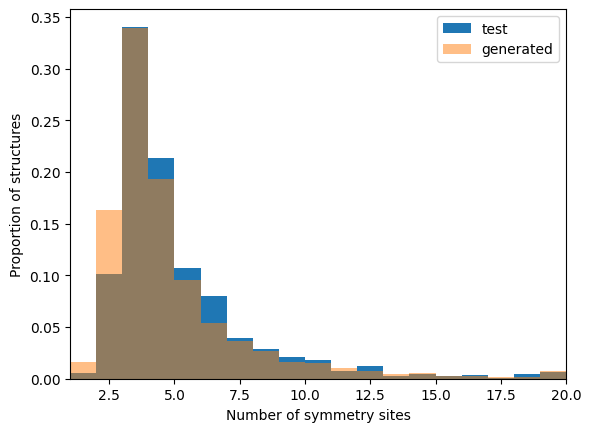

In [17]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
#ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: sum(map(len, s['sites'])), generated_structures)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len-1);

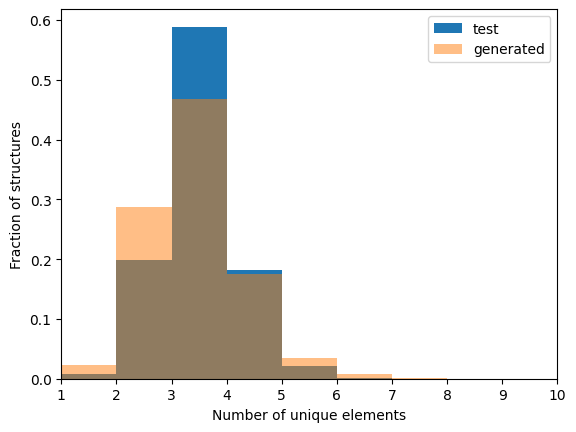

In [18]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
#ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, generated_structures)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
ax.set_xlim((1,10));

In [19]:
import pyxtal
example = generated_structures[2]
generator = pyxtal.pyxtal()
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["composition"], sites=example["sites"])

In [20]:
example

{'spacegroup': 65,
 'sites': [['2c'], ['4i'], ['4i']],
 'elements': ['Cu', 'Ag', 'O'],
 'composition': [2, 4, 4]}

In [21]:
ase_struct = generator.to_ase()
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [22]:
import json
with open("generated.json", "w") as f:
    json.dump(generated_structures, f)